In [15]:
"""
What this notebook currently does
--------------------------------
1. Estimates noise properties from TSP data

2. Creates a DRW simulation for a single light curve from TSP dataset
    2.1. Takes the input parameters from the fit of the real data, which was done separately
    2.2. It outputs a parquet file with the simulated light curves
    
What this notebook will do in the future
--------------------------------
3. Create a DRW simulation for all light curves in the TSP dataset
4. Create a DRW simulation for all AGN lightcuves in ZTF
"""

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# eztao imports
import eztao
from eztao.carma import DHO_term, CARMA_term, DRW_term
from eztao.ts import gpSimFull, gpSimByTime, addNoise
from eztao.ts.carma_fit import sample_carma

from tape.ensemble import Ensemble
from tape.utils import ColumnMapper
from tape.analysis import calc_sf2

from tqdm import tqdm

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46735 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46735/status,
Dashboard: http://127.0.0.1:46735/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38571,Workers: 8
Dashboard: http://127.0.0.1:46735/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:38303,Total threads: 8
Dashboard: http://127.0.0.1:34629/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:42892,


2024-01-02 08:31:28,805 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.
2024-01-02 08:31:28,809 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.
2024-01-02 08:31:28,811 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.
2024-01-02 08:31:28,812 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.
2024-01-02 08:31:28,813 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.
2024-01-02 08:31:28,815 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.
2024-01-02 08:31:28,815 - distributed.core - INFO - Connection to tcp://127.0.0.1:38571 has been closed.


# Tape Single Pixel

In [3]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True)

/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1736: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1758: UserWarning: Divisions are not known, syncing using a non-lazy method.
  warnings.warn("Divisions are not known, syncing using a non-lazy method.")
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1286: UserWarning: Divisions for object are not set, certain downstream dask operations may fail as a result. We recommend setting the `sort` or `sorted` flags when loading data to establish division information.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/tape/ensemble.py:1286: UserWarning: Divisions for source are not set, certain downstream dask operations may fail a

## 0. Estimate noise for ztf 

In [4]:
ens_g = ens.source.query("band_ztf_source == 'g'")
ens_r = ens.source.query("band_ztf_source == 'r'")


In [5]:
# can I do that as a single function call for both bands, without restarting?
# ens.query("band_ztf_source == 'g'", table = 'source')
# ens.source.compute()

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024311.71-010928.3,4996744218186612736,7337,56662,360,40.798814,-1.157879,7337-56662-0360,BOSS,0.778,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
024300.73+010915.0,4997869293954662400,4240,55455,822,40.753060,1.154190,4240-55455-0822,BOSS,2.474,VI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1


In [6]:
# can I do that as a single function call for both bands, without restarting?
# ens.query("band_ztf_source == 'r'", table = 'source')
# ens.source.compute()

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/array/core.py:1726: RankWarning: Polyfit may be poorly conditioned
  return func(*args, **kwargs)
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/dask/array/core.py:1726: RankWarning: Polyfit may be poorly conditioned
  retur

          3           2
0.000139 x - 0.00202 x - 0.04211 x + 0.6348
           3             2
4.827e-05 x + 0.0003963 x - 0.004047 x - 0.3294
           3            2
0.0001298 x - 0.001805 x - 0.04003 x + 0.5832
           3             2
5.013e-05 x + 0.0004016 x - 0.004294 x - 0.3354


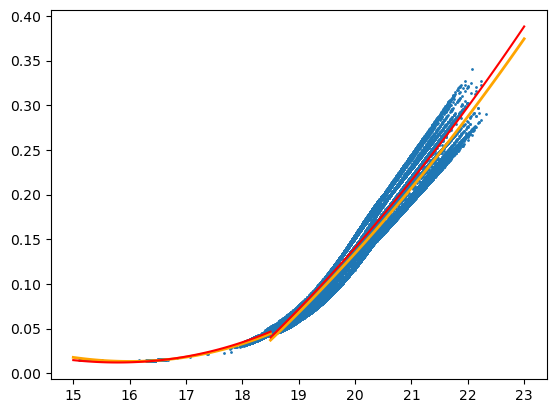

In [5]:
# y = ens.source['mag_ztf_source'].compute().values
# y_err = ens.source['magerr_ztf_source'].compute().values


y_g = ens_g['mag_ztf_source'].values
y_g_err = ens_g['magerr_ztf_source'].values
y_r = ens_r['mag_ztf_source'].values
y_r_err = ens_r['magerr_ztf_source'].values

g_polyfit_l18 = np.poly1d(np.polyfit(y_g[y_g<18.5] , y_g_err[y_g<18.5], deg=3))
g_polyfit_g18 = np.poly1d(np.polyfit(y_g[y_g>18.5] , y_g_err[y_g>18.5], deg=3))
r_polyfit_l18 = np.poly1d(np.polyfit(y_r[y_r<18.5] , y_r_err[y_r<18.5], deg=3))
r_polyfit_g18 = np.poly1d(np.polyfit(y_r[y_r>18.5] , y_r_err[y_r>18.5], deg=3))

x_l18 = np.linspace(15, 18.5, 100)
x_g18 = np.linspace(18.5, 23, 100)

plt.scatter(ens_g['mag_ztf_source'], ens_g['magerr_ztf_source'], s=1)
plt.plot(x_l18, g_polyfit_l18(x_l18), c='orange', lw = 2)
plt.plot(x_g18, g_polyfit_g18(x_g18), c='orange', lw = 2)
plt.plot(x_l18, r_polyfit_l18(x_l18), c='r')
plt.plot(x_g18, r_polyfit_g18(x_g18), c='r')


print(g_polyfit_l18)
print(g_polyfit_g18)
print(r_polyfit_l18)
print(r_polyfit_g18)

In [6]:
def err_func_f(mag, band = 'g'):
    if band == 'g':
        g_polyfit_l18 = np.poly1d([ 1.38997304e-04, -2.02030371e-03, -4.21095110e-02,  6.34775050e-01])
        g_polyfit_g18 = np.poly1d([ 4.82657946e-05,  3.96290863e-04, -4.04700576e-03, -3.29367881e-01])
        if mag <= 18.5:
            return g_polyfit_l18(mag)
        else:
            return g_polyfit_g18(mag)
    elif band == 'r':
        r_polyfit_l18 = np.poly1d([ 1.29781163e-04, -1.80534691e-03, -4.00305229e-02,  5.83242718e-01])
        r_polyfit_g18 = np.poly1d([ 5.01335528e-05,  4.01610345e-04, -4.29364079e-03, -3.35432920e-01])
        if mag <= 18.5:
            return r_polyfit_l18(mag)
        else:
            return r_polyfit_g18(mag)
    
v_err_func_f = np.vectorize(err_func_f)

# 1. Creating simulations - Single object

In [7]:
name_str = '023922.87-000119.6'

ts_computed = ens.source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

t_g = ts_computed_g['mjd_ztf_source'].values
sort_array = np.argsort(t_g)
t_g = t_g[sort_array]
y_g = ts_computed_g['mag_ztf_source'].values[sort_array]
yerr_g = ts_computed_g['magerr_ztf_source'].values[sort_array]

In [8]:
# Setup base directory for loading files
username= "ncaplar"
basedir = f"/astro/users/{username}/data"

# what are the parameters that we got from the fitting of the real data?
res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')

res_tsp_run_0_drw

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
SDSS_NAME_dr16q_constant,,,,,,
024050.36-003109.0,40.089910,40.089910,2.980099,-0.760837,3.534287,0.225864
024052.82-004110.9,-34.805998,-34.805998,-3.807629,-4.933484,0.979914,0.808098
024126.71-004526.3,-28.434609,-28.434609,2.066565,-1.248880,1.872701,-2.842854
024151.76-001953.6,35.285865,35.285865,2.441909,-1.277017,3.854836,-1.304851
024154.42-004757.6,-12.792811,-12.792811,1.545028,-4.170314,1.554912,-1.710292
...,...,...,...,...,...,...
024419.10+005539.2,-94.101120,-94.101120,2.633371,-0.931073,2.623782,-2.067150
024448.90+002858.6,-72.338187,-72.338187,2.415671,-0.888955,3.037724,-0.912945
024504.47+002841.3,13.080527,13.080527,2.468771,-0.839532,1.792329,1.683650


In [9]:
single_res = res_tsp_run_0_drw[res_tsp_run_0_drw.index == name_str]
single_res

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
SDSS_NAME_dr16q_constant,,,,,,
023922.87-000119.6,-358.138073,-358.138073,2.7498,-0.935381,1.061696,1.040602


## 1.1. Creating single simulation with added periods

In [10]:
# Creating DRW component

# sorted times of observations
t_start = np.min(ts_computed_g['mjd_ztf_source'].values)
tIn = np.sort(ts_computed_g['mjd_ztf_source'].values) - np.min(ts_computed_g['mjd_ztf_source'].values)

# number of light curves to simulate
nLC = 100
# very high SNR as we are going to add noise later manually
SNR = 100

single_log_drw_amp = single_res['log_drw_amp'].values[0]
single_log_drw_scale = single_res['log_drw_scale'].values[0]
# define a DRW kernel taken from the first simulation
# at the moment I am putting the values by hand, TBD to automate this
amp = 10**(single_log_drw_amp)
tau = 10**(single_log_drw_scale)
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

# simulate light curves
t, y, yerr = gpSimByTime(DRW_kernel , SNR, tIn, nLC=nLC, log_flux=True)
y = np.median(ts_computed_g['mag_ztf_source']) + y 

y_drw = np.copy(y)


# Creating periodic component

## random periods and amplitudues
per_amp = np.insert(np.random.uniform(0, 0.5, nLC-1),0,0)
per_tau = np.insert(10**np.random.uniform(1, 4, nLC-1),0,9999999)
per_phase = np.random.uniform(0, 2*np.pi, nLC)


y_per = np.array([per_amp[i] * np.sin(2*np.pi*(t[i])/per_tau[i] + per_phase[i]) for i in range(nLC)])
# add periodic component
y = y + y_per


# add noise
yerr = v_err_func_f(y)
y = addNoise(y, yerr)

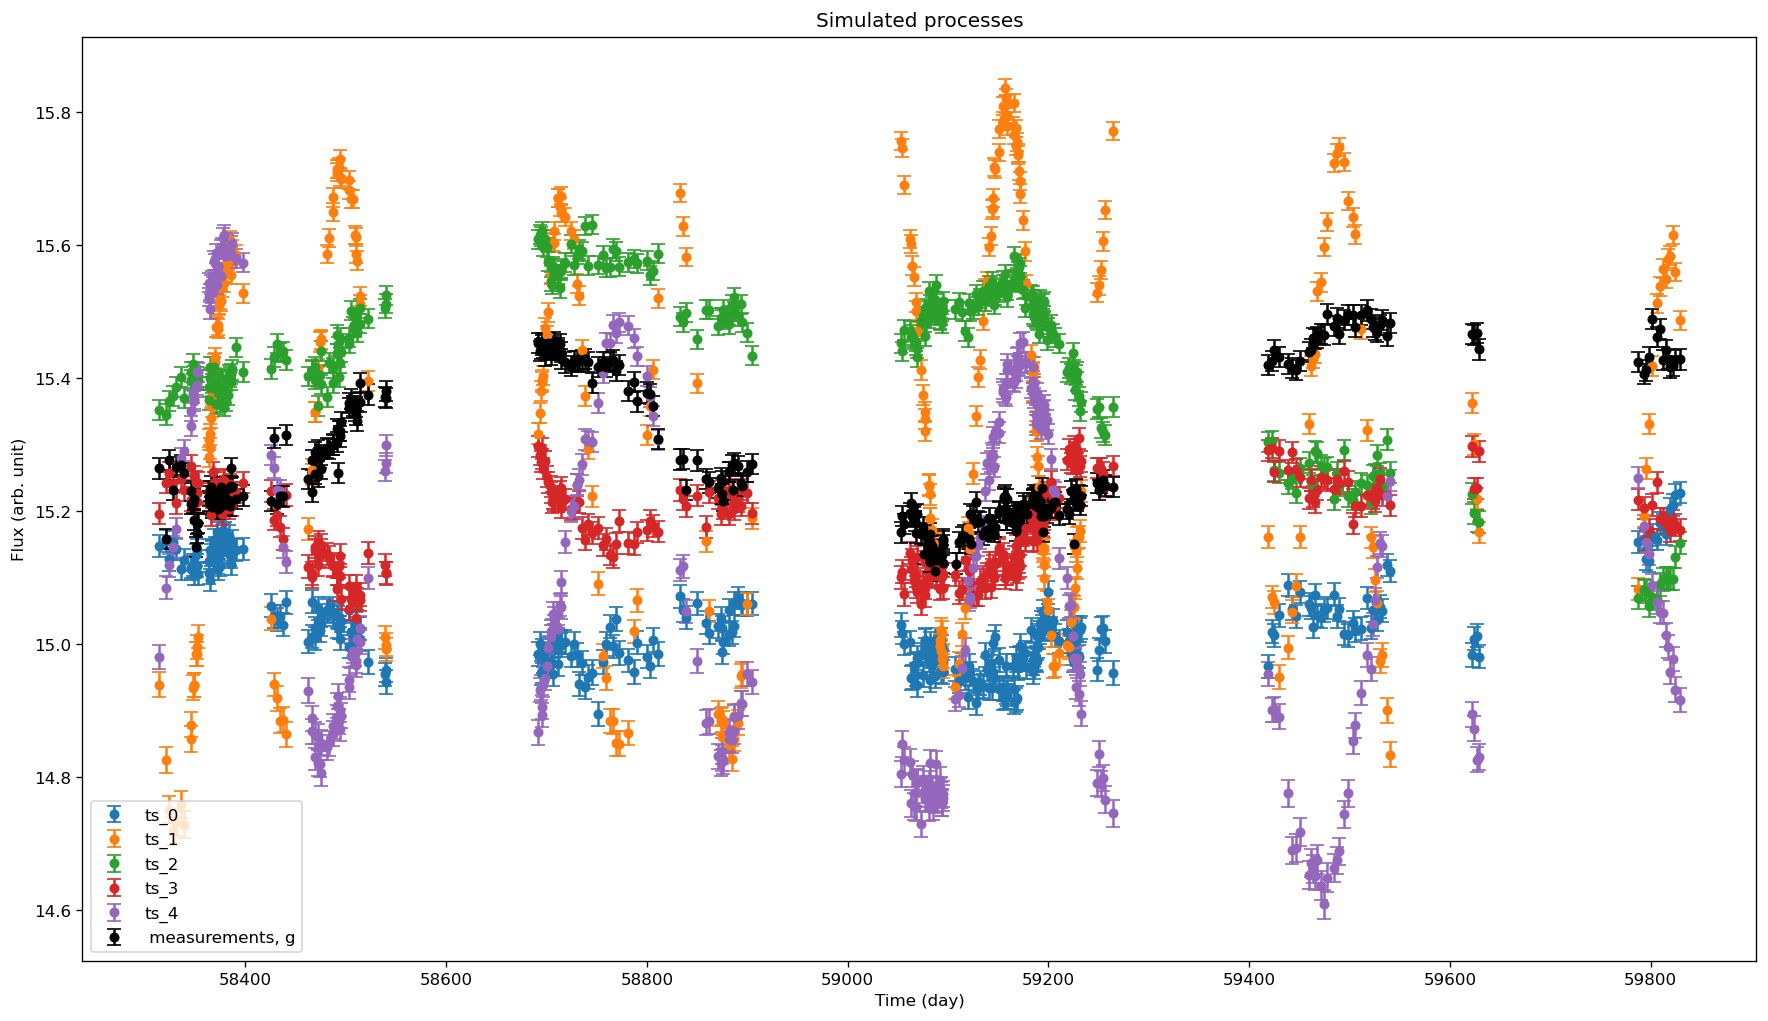

In [11]:
# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=120, figsize=(18,10))

for i in range(nLC)[:5]:
    ax.errorbar(t[i]+t_start, y[i], yerr[i], fmt='.', label=f'ts_{i}', ms=10, capsize=4)
    
ax.errorbar(t_g, y_g, yerr=yerr_g, fmt=".k", capsize=4, label = ' measurements, g', ms=10)

ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated processes')
ax.legend(markerscale=1, loc=3)

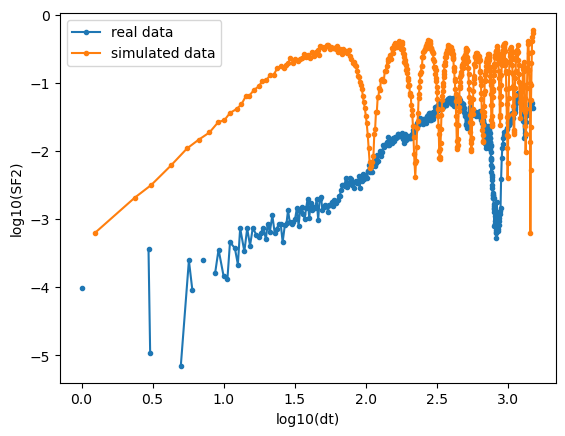

In [12]:
sf_real = calc_sf2(t_g, y_g, yerr_g)
sf_fake = calc_sf2(t[1], y[1], yerr[1])

plt.plot(np.log10(sf_real['dt']), np.log10(sf_real['sf2']), label = 'real data', marker='.')
plt.plot(np.log10(sf_fake['dt']), np.log10(sf_fake['sf2']), label = 'simulated data', marker='.')
plt.xlabel('log10(dt)')
plt.ylabel('log10(SF2)')
plt.legend()

In [13]:
# creating dataframe 
num_lightcurves, num_points = t.shape

# Flatten the 2D arrays
t_flat = t.flatten()
y_flat = y.flatten()
yerr_flat = yerr.flatten()

y_drw_flat = y_drw.flatten()
y_per_flat = y_per.flatten()

# Create a DataFrame - contains both combined lightcurves, as well as the individual components
df = pd.DataFrame({
    'lc_nr': np.repeat(np.arange(num_lightcurves), num_points),
    'drw_amp': np.repeat(np.full(num_lightcurves, amp), num_points),
    'drw_tau': np.repeat(np.full(num_lightcurves, tau), num_points),
    'per_amp': np.repeat(np.full(num_lightcurves, per_amp), num_points),
    'per_tau': np.repeat(np.full(num_lightcurves, per_tau), num_points),
    't': t_flat,
    'y': y_flat,
    'yerr': yerr_flat,
    'y_drw': y_drw_flat,
    'y_per': y_per_flat,
    'band': np.repeat(np.full(num_lightcurves, 'g'), num_points)
})

In [14]:
df

,lc_nr,drw_amp,drw_tau,per_amp,per_tau,t,y,yerr,y_drw,y_per,band
0,0,0.116043,562.081914,0.000000,9.999999e+06,0.000000,15.148292,0.016716,15.114692,0.000000,g
1,0,0.116043,562.081914,0.000000,9.999999e+06,7.056726,15.155945,0.016493,15.143294,0.000000,g
2,0,0.116043,562.081914,0.000000,9.999999e+06,9.997028,15.127502,0.016568,15.133529,0.000000,g
3,0,0.116043,562.081914,0.000000,9.999999e+06,14.113451,15.153920,0.016510,15.141054,0.000000,g
4,0,0.116043,562.081914,0.000000,9.999999e+06,17.053754,15.142693,0.016552,15.135613,0.000000,g
...,...,...,...,...,...,...,...,...,...,...,...
32995,99,0.116043,562.081914,0.404696,4.464374e+03,1504.062670,15.142224,0.016588,15.288043,-0.157045,g
32996,99,0.116043,562.081914,0.404696,4.464374e+03,1506.022871,15.119594,0.016689,15.276186,-0.158073,g
32997,99,0.116043,562.081914,0.404696,4.464374e+03,1508.963174,15.142050,0.016587,15.290707,-0.159613,g
32998,99,0.116043,562.081914,0.404696,4.464374e+03,1510.923375,15.150002,0.016616,15.287945,-0.160639,g


In [15]:
df.to_parquet('/epyc/users/ncaplar/data/drw_per_sim/sources/test_simulated_data.parquet')

# 2. Creating simulations many lightcurves - Tape Single Pixel

## Creating simulations with pure DRW

In [7]:
sdss_id = ens.object.index.compute()
sdss_id.values[556]

'024355.78+001127.5'

In [13]:
"""

name_str = '023922.87-000119.6'



ts_computed = ens.source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
# ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']

# time
t_g = ts_computed_g['mjd_ztf_source'].values
sort_array = np.argsort(t_g)
t_g = t_g[sort_array]
# y
y_g = ts_computed_g['mag_ztf_source'].values[sort_array]
# yerr
yerr_g = ts_computed_g['magerr_ztf_source'].values[sort_array]

# sorted times of observations
t_start = np.min(ts_computed_g['mjd_ztf_source'].values)
tIn = np.sort(ts_computed_g['mjd_ztf_source'].values) - np.min(ts_computed_g['mjd_ztf_source'].values)

# number of light curves to simulate
nLC = 100
# very high SNR as we are going to add noise later manually
SNR = 100

single_log_drw_amp = single_res['log_drw_amp'].values[0]
single_log_drw_scale = single_res['log_drw_scale'].values[0]
# define a DRW kernel taken from the first simulation
# at the moment I am putting the values by hand, TBD to automate this
amp = 10**(single_log_drw_amp)
tau = 10**(single_log_drw_scale)
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

# simulate light curves
t, y, yerr = gpSimByTime(DRW_kernel , SNR, tIn, nLC=nLC, log_flux=True)
y = np.median(ts_computed_g['mag_ztf_source']) + y 
y_drw = np.copy(y)

# Creating periodic component
## random periods and amplitudues
per_amp = np.insert(np.random.uniform(0, 0.5, nLC-1),0,0)
per_tau = np.insert(10**np.random.uniform(1, 4, nLC-1),0,9999999)
per_phase = np.random.uniform(0, 2*np.pi, nLC)

y_per = np.array([per_amp[i] * np.sin(2*np.pi*(t[i])/per_tau[i] + per_phase[i]) for i in range(nLC)])
# add periodic component
y = y + y_per

# add noise
yerr = v_err_func_f(y)
y = addNoise(y, yerr)

"""

"\n\nname_str = '023922.87-000119.6'\n\n\n\nts_computed = ens.source.compute().loc[name_str]\nts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']\n# ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']\n\n# time\nt_g = ts_computed_g['mjd_ztf_source'].values\nsort_array = np.argsort(t_g)\nt_g = t_g[sort_array]\n# y\ny_g = ts_computed_g['mag_ztf_source'].values[sort_array]\n# yerr\nyerr_g = ts_computed_g['magerr_ztf_source'].values[sort_array]\n\n# sorted times of observations\nt_start = np.min(ts_computed_g['mjd_ztf_source'].values)\ntIn = np.sort(ts_computed_g['mjd_ztf_source'].values) - np.min(ts_computed_g['mjd_ztf_source'].values)\n\n# number of light curves to simulate\nnLC = 100\n# very high SNR as we are going to add noise later manually\nSNR = 100\n\nsingle_log_drw_amp = single_res['log_drw_amp'].values[0]\nsingle_log_drw_scale = single_res['log_drw_scale'].values[0]\n# define a DRW kernel taken from the first simulation\n# at the moment I am putting the

In [43]:
def create_drw_simulation_for_single_lc(id, t, y, yerr, single_log_drw_amp, single_log_drw_scale, nLC=100):
    """Creates simulated light curves corresponding to a single real object, given the input parameters.
    
    Inputs:
    -------
    id: str
        SDSS name of the object
    t: array
        times of observations
    y: array    
        fluxes of observations
    yerr: array
        errors of observations
    single_log_drw_amp: float
        log10 of the amplitude of the DRW component
    single_log_drw_scale: float
        log10 of the scale of the DRW component
    nLC: int
        number of light curves to simulate
        
    Returns:
    --------
    df: DataFrame
        DataFrame containing the simulated light curves, as well as the input parameters 
    """
    # first sort the data
    sort_array = np.argsort(t)
    t = t[sort_array]
    y = y[sort_array]
    yerr = yerr[sort_array]
    
    # sorted times of observations
    t_start = np.min(t)
    tIn = t - t_start

    # define a DRW kernel taken from the first simulation
    # at the moment I am putting the values by hand, TBD to automate this
    amp = 10**(single_log_drw_amp)
    tau = 10**(single_log_drw_scale)
    DRW_kernel = DRW_term(np.log(amp), np.log(tau))
    
    # simulate light curves
    t, y, yerr = gpSimByTime(DRW_kernel , SNR, tIn, nLC=nLC, log_flux=True)
    # add the median value to get roughly the correct magnitude
    y = np.median(ts_computed_g['mag_ztf_source']) + y 
    
    # add noise
    yerr = v_err_func_f(y)
    print(yerr)
    y = addNoise(y, yerr)
    
    num_lightcurves, num_points = t.shape
    # Flatten the 2D arrays
    t_flat = t.flatten()
    y_flat = y.flatten()
    yerr_flat = yerr.flatten()
        
    # Create a DataFrame - contains lightcurves, as well as the input parameters
    df = pd.DataFrame({
        'id': np.repeat(np.full(num_lightcurves, id), num_points),
        'lc_nr': np.repeat(np.arange(num_lightcurves), num_points),
        'drw_amp': np.repeat(np.full(num_lightcurves, amp), num_points),
        'drw_tau': np.repeat(np.full(num_lightcurves, tau), num_points),
        't': t_flat,
        'y': y_flat,
        'yerr': yerr_flat,
        'band': np.repeat(np.full(num_lightcurves, 'g'), num_points)
    })
    
    return df
    


In [11]:
# Setup base directory for loading files
username= "ncaplar"
basedir = f"/astro/users/{username}/data"

# what are the parameters that we got from the fitting of the real data?
res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')


In [39]:
name_str = '023922.87-000119.6'

# This fails because input parameters make no sense

SNR = 100
for name_str in tqdm(res_tsp_run_0_drw.index):
    # select a single object, and its parameters
    single_res = res_tsp_run_0_drw[res_tsp_run_0_drw.index == name_str]
    single_log_drw_amp = single_res['log_drw_amp'].values[0]
    single_log_drw_scale = single_res['log_drw_scale'].values[0]

    # get the ligthcurves data for this object
    ts_computed = ens.source.compute().loc[name_str]
    ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
    # ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']
    # time 
    t_g = ts_computed_g['mjd_ztf_source'].values
    sort_array = np.argsort(t_g)
    t_g = t_g[sort_array]
    # y
    y_g = ts_computed_g['mag_ztf_source'].values[sort_array]
    # yerr
    yerr_g = ts_computed_g['magerr_ztf_source'].values[sort_array]

    drw_sim_single_lc=\
        create_drw_simulation_for_single_lc(id=name_str,
                                            t=t_g,
                                            y=y_g,
                                            yerr=yerr_g,
                                            single_log_drw_amp=single_log_drw_amp,
                                            single_log_drw_scale=single_log_drw_scale,
                                            nLC=100) 

 12%|█▏        | 15/127 [00:33<04:09,  2.22s/it]


ValueError: scale < 0

In [29]:
drw_sim_single_lc

,id,lc_nr,drw_amp,drw_tau,t,y,yerr,band
0,023922.87-000119.6,0,0.116043,562.081914,0.000000,14.989332,0.017533,g
1,023922.87-000119.6,0,0.116043,562.081914,7.056726,15.038355,0.017255,g
2,023922.87-000119.6,0,0.116043,562.081914,9.997028,15.018960,0.017310,g
3,023922.87-000119.6,0,0.116043,562.081914,14.113451,15.032794,0.017472,g
4,023922.87-000119.6,0,0.116043,562.081914,17.053754,15.003908,0.017527,g
...,...,...,...,...,...,...,...,...
32995,023922.87-000119.6,99,0.116043,562.081914,1504.062670,15.138298,0.016486,g
32996,023922.87-000119.6,99,0.116043,562.081914,1506.022871,15.186152,0.016377,g
32997,023922.87-000119.6,99,0.116043,562.081914,1508.963174,15.170980,0.016370,g
32998,023922.87-000119.6,99,0.116043,562.081914,1510.923375,15.170053,0.016424,g


In [47]:
name_str = res_tsp_run_0_drw.index[15]

single_res = res_tsp_run_0_drw[res_tsp_run_0_drw.index == name_str]
single_log_drw_amp = single_res['log_drw_amp'].values[0]
single_log_drw_scale = single_res['log_drw_scale'].values[0]

# get the ligthcurves data for this object
ts_computed = ens.source.compute().loc[name_str]
ts_computed_g = ts_computed[ts_computed['band_ztf_source']=='g']
# ts_computed_r = ts_computed[ts_computed['band_ztf_source']=='r']
# time 
t_g = ts_computed_g['mjd_ztf_source'].values
sort_array = np.argsort(t_g)
t_g = t_g[sort_array]
# y
y_g = ts_computed_g['mag_ztf_source'].values[sort_array]
# yerr
yerr_g = ts_computed_g['magerr_ztf_source'].values[sort_array]

drw_sim_single_lc=\
create_drw_simulation_for_single_lc(id=name_str,
                                    t=t_g,
                                    y=y_g,
                                    yerr=yerr_g,
                                    single_log_drw_amp=single_log_drw_amp,
                                    single_log_drw_scale=single_log_drw_scale,
                                    nLC=100) 

[[ 1.80138375e+18  1.80138367e+18  1.80138380e+18 ...  1.80137532e+18
   1.80137520e+18  1.80137514e+18]
 [-1.92684733e+13 -1.92686010e+13 -1.92689682e+13 ... -1.92675715e+13
  -1.92679519e+13 -1.92680534e+13]
 [-4.03714530e+18 -4.03714760e+18 -4.03714726e+18 ... -4.03714188e+18
  -4.03714257e+18 -4.03714266e+18]
 ...
 [-3.39613695e+18 -3.39613588e+18 -3.39613664e+18 ... -3.39614601e+18
  -3.39614581e+18 -3.39614549e+18]
 [ 3.38574393e+17  3.38574361e+17  3.38574272e+17 ...  3.38572574e+17
   3.38572436e+17  3.38572543e+17]
 [ 1.51347359e+17  1.51347438e+17  1.51347504e+17 ...  1.51347170e+17
   1.51347176e+17  1.51347246e+17]]


ValueError: scale < 0

In [49]:
single_log_drw_amp

7.630028638232311

In [28]:
yerr = v_err_func_f(y_g)


In [33]:

y = addNoise(y_g, yerr)
y

array([19.65742873, 19.5554466 , 19.54733429, 19.49020429, 19.58801439,
       19.94796595, 19.49353526, 19.8173656 , 19.77822958, 19.58823616,
       19.85541213, 19.5642879 , 19.79777585, 19.74430007, 19.71032297,
       19.97757674, 19.67302192, 19.75348834, 19.64585521, 19.86892957,
       19.63255338, 19.70754036, 19.5313696 , 19.70762293, 19.59637602,
       19.64713819, 19.81265542, 19.55913024, 19.7300817 , 19.56095852,
       19.72067849, 19.51336668, 19.54398795, 19.55743776, 19.77538371,
       19.2982883 , 19.47974608, 19.62975335, 19.53917795, 19.58481942,
       20.07468982, 19.66335941, 19.74173426, 19.93489621, 19.8924116 ,
       19.34178318, 19.73604012, 19.79602029, 19.62269724, 19.51302996,
       19.68235194, 19.61482282, 19.54724339, 19.32387868, 19.63020239,
       19.53030676, 19.34679293, 19.59162088, 19.66209111, 19.20546327,
       19.38462846, 19.83807898, 19.71309917, 19.58979615, 19.73140204,
       19.6139556 , 19.52546032, 19.56131356, 19.44414659, 19.74